# Total Variation (TV) denoising

*Louis Martinez*

[Link to the paper](./References/total_variation.pdf)

Here is implemented the total variation denoising based on the class taught by Said Ladjal at Telecom Paris

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from skimage.io import imread, imshow

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['font.size'] = 12

We want to minimize the following energy function :

$$E(u) = \|u-v\|^2+\lambda\, TV(u)$$

where $v$ is the noisy image and $u$ the denoised image

We minimize $E$ with a gradient descent :

$$\nabla E(u) = 2(u-v)-\lambda\,div\left(\frac{\nabla u}{\|u\|}\right)$$

In [2]:
def gaussian_kernel(s, std):
    """
    Create a 2D centered gaussian kernel

    s : size of the kernel (must be odd)
    std : standard deviation of the kernel
    """
    K = np.fromfunction(lambda x, y : (1/(2*np.pi*std**2)) * np.exp(-((x-(s//2))**2+(y-(s//2))**2) / (2*std**2)), (s, s))
    return K/np.sum(K)


def apply_filter(im, K):
    """
    Aplies a filter kernel to an image 

    K : 2D kernel to apply to the image
    im : grayscale image which filter to be applied
    """
    w, h = im.shape
    im_ft = np.fft.fft2(im)
    K_ft = np.fft.fft2(K, [w, h])
    return np.real(np.fft.ifft2(im_ft * K_ft))

def norm2(im):
    return ((im**2).sum())**0.5


def gradient(im):
    w, h = im.shape
    grad_x = np.zeros((w, h))
    grad_x[:,:-1] = im[:,1:]-im[:,:-1]
    grad_x[:,-1] = np.zeros((w,))

    
    grad_y = np.zeros((w, h))
    grad_y[:-1,:] = im[1:,:]-im[:-1,:]
    grad_y[-1,:] = np.zeros((h,))

    return np.stack([grad_x, grad_y], axis=2).transpose(2, 0, 1)

def random_noise(im,noise): 
    """
    Add gaussian noise to an image
    """
    out=im+noise*np.random.randn(*im.shape)
    return out

def divergence(gx, gy):
    r, c = gx.shape

    dx = np.zeros((r, c))
    dx[:,1:-1] = gx[:,1:-1]-gx[:,:-2]
    dx[:,0] = gx[:,0]
    dx[:,-1] = -gx[:,-2]

    dy = np.zeros((r, c))
    dy[1:-1,:] = gy[1:-1,:]-gy[:-2,:]
    dy[0,:] = gy[0,:]
    dy[-1,:] = -gy[-2,:]
    return dx+dy

def TV_norm(im):
    gx, gy = gradient(im)
    norm = np.sum((gx**2 + gy**2)**0.5)
    return norm

def energy(u,v,lamb):
    return norm2(u-v)**2 + lamb * TV_norm(u)

def energy_grad(u,v,lamb):
    """
        v       : noisy image
        u       : denoised image
        lamb    : constant for TV
    """
    gx, gy = gradient(u)
    norm = ((gx**2)+(gy**2))**0.5 + 1e-15
    div = divergence(gx/norm, gy/norm)
    return 2*(u-v) - lamb*div

def minimize_TV(v, lamb, step, n_steps):
    """
        v       : image to denoise
        lamb    : mltlicative constant TV
        step    : update step
        n_steps : number of steps
    """
    u = np.zeros(v.shape)
    energies = [energy(u,v,lamb)]

    for i in tqdm(range(n_steps)):
        u = u - step * energy_grad(u,v,lamb)
        energies.append(energy(u,v,lamb))

    return u, energies

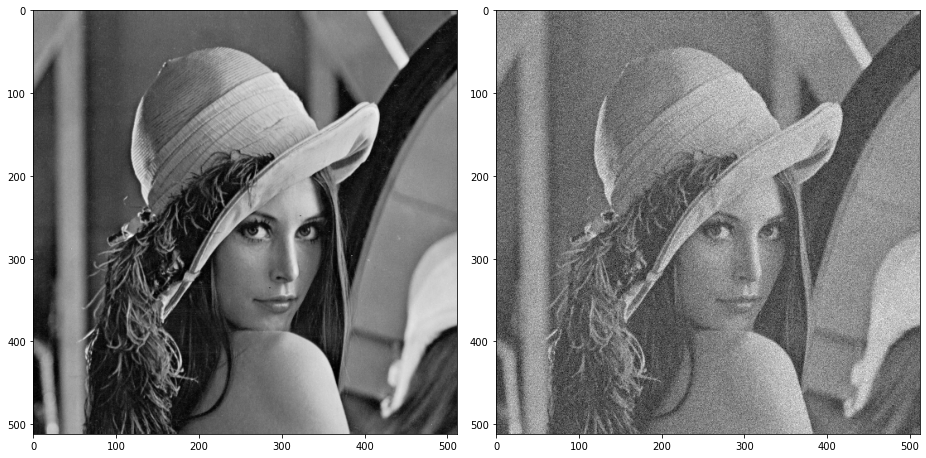

In [3]:
im = imread('./images/lena.tif')
im_n = random_noise(im, 25)

fig, ax = plt.subplots(1, 2, figsize=(13, 7))
ax[0].imshow(im)
ax[1].imshow(im_n)
plt.tight_layout()

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:09<00:00, 21.38it/s]


Text(0.5, 1.0, 'Energy')

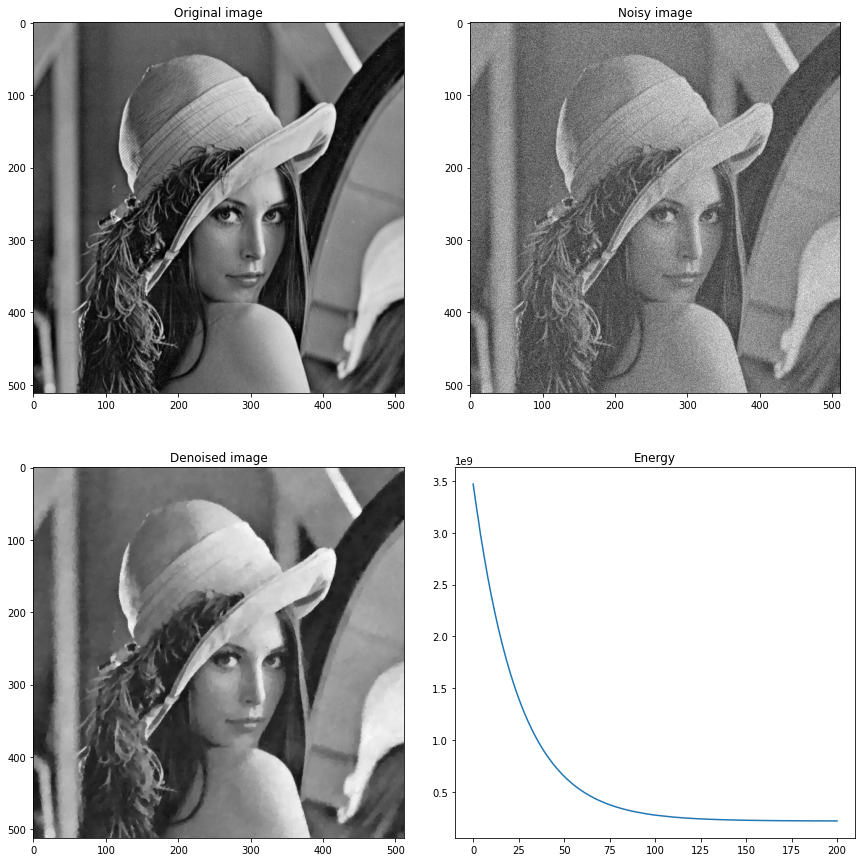

In [4]:
denoised, energies = minimize_TV(im_n, lamb=50, step=0.01, n_steps=200)
fig, ax = plt.subplot_mosaic('''
AABB
CCDD
''', figsize=(15,15))
ax['A'].imshow(im)
ax['A'].set_title('Original image')
ax['B'].imshow(im_n)
ax['B'].set_title('Noisy image')
ax['C'].imshow(denoised)
ax['C'].set_title('Denoised image')
ax['D'].plot(energies)
ax['D'].set_title('Energy')
plt.tight_layout()
plt.show()

---
## Chambolle Projection algorithm

This section is dedicated to the implementation of Chambolle Algorithm for total variation denoising.